# Research Summary for July 11th, 2023

By: Bora Basyildiz 

## Imports

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
plt.rcParams["mathtext.fontset"] = 'cm'

def genPlot(fname,df,l,m="o",msize=5):
    plt.plot(df["time"],df["fidelity"],marker=m,markersize=msize)
    plt.xlabel('$T/T_{min}$',fontsize=16)
    plt.ylabel('$F$',fontsize=16)
    plt.title(fname)
    plt.grid(which='major', linestyle='-', linewidth='0.5')
    plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
    plt.minorticks_on()
    plt.legend(l)
mainDir = "Figures/Summary_0711/"
try: #All files are stored under their gateType
    os.makedirs(mainDir)
except:
    pass 
#plt.savefig(os.path.join(os.getcwd(),mainDir,"Ashhab_Hopping.pdf"), format="pdf")


## Operator Norm Analysis

Here we will compare the newest iSWAP protocol operator norm vs. the capacitive coupling operator norm. If the capactive coupling norm is greater than our protocol's norm, then the addition of extra couplings leads to a speed-up. Otherwise the additional couplings are not relavent to the dark evolution of the Hamiltonian. 

Using the code developed earlier, we have

In [12]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
def OpNorm(elevel):
    #Takes in Energy Levels and outputs operator norm of the normalized and non-normalized Ashabb Hamiltonian
    splus = np.zeros([elevel,elevel])
    splusn = np.zeros([elevel,elevel])
    for e in range(elevel-1):
        splus[e,e+1] = np.sqrt(e+1)
        splusn[e,e+1] = 1
    
    H = splus + np.transpose(splus)
    H = np.kron(H,H)
    normH = splusn + np.transpose(splusn)
    normH = np.kron(normH,normH)

    if elevel > 2:
        H = csr_matrix(H)
        normH = csr_matrix(normH)
        [evals,evecs] = eigs(H)
        [evalsn,evecsn] = eigs(normH)
        return [abs(max(evals,key=abs)),abs(max(evalsn,key=abs))]
    else: return [abs(max(np.linalg.eigvals(H),key=abs)),abs(max(np.linalg.eigvals(normH),key=abs))]


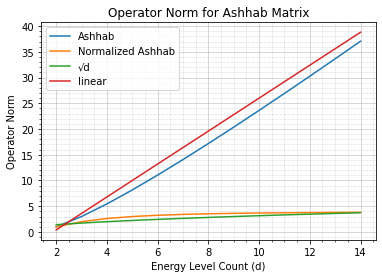

In [13]:
elevels = np.array([int(i) for i in range(2,15)])
norms = [OpNorm(e) for e in elevels]
roots = [np.sqrt(e) for e in elevels]
squares = [e ** 2 for e in elevels]

plt.plot(elevels,norms)
plt.plot(elevels,roots)
plt.plot(elevels,3.2*elevels - 6)

plt.xlabel("Energy Level Count (d)")
plt.ylabel("Operator Norm")
plt.title("Operator Norm for Ashhab Matrix")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()
plt.legend(["Ashhab","Normalized Ashhab","\u221Ad","linear"])
plt.savefig(os.path.join(os.getcwd(),"Figures/","Ashhab_OpNorm.pdf"), format="pdf")

## Protocol Time Comparison

Here we will compare the time of our analytical protocol to our qubit and numerics. 

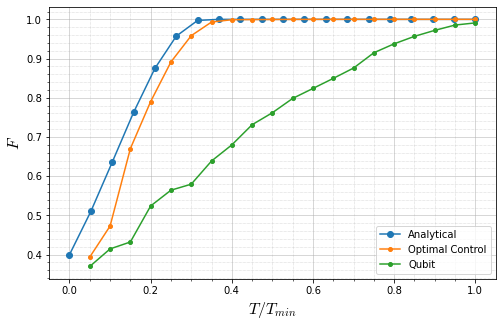

In [14]:
import numpy as np 
from numpy import array,sqrt,kron,pi,eye,trace,arctan,argmax,matmul,linspace
from scipy.linalg import expm
from itertools import product
import matplotlib.pyplot as plt
import os

#Printing statement for Matrices
def printH(H0):
    for row in H0:
        for val in row:
            if val > 10:
                print(f"{val:.{1}f}",end=" ")
            else:
                print(f"{val:.{2}f}",end=" ")
        print()

'''
Protocol_Fid: Calculates gate fidelity for iSWAP Analytical Protocol
Inputs: 
    t ~ angle for the dark evolution of the Hamiltonian
    Hvals ~ values of entires in Hamiltonian (may be unit values, unequal superposition, or any other input)
    theta ~ rotation of qutrit unitary matrices (arctan(sqrt(2)) for speed-up)

Output: Fidelity of protocol sequence when compared to the iSWAP qubit gate.  
'''
def Protocol_Fid(t,Hvals,theta):
    qx = array([[0,0,1],[0,0,0],[1,0,0]])
    qy = array([[0,0,-1j],[0,0,0],[1j,0,0]])
    x = array([[0,1,0],[1,0,0],[0,0,0]])
    H = np.zeros([3 ** 2, 3 ** 2])
    H[0,4] = Hvals[0]
    H[2,4] = Hvals[1]
    H[6,4] = Hvals[2]
    H[8,4] = Hvals[3]
    H = H + H.transpose()

    U1 = kron(expm(-1j*qy*theta),eye(3))
    U2 = kron(eye(3),expm(-1j*qy*theta))
    X2 = kron(eye(3),expm(-1j*x*-pi/2))

    U = -1*X2 @ U1.conj().T @ U2.conj().T @ expm(-1j*t*H) @ U2 @ U1 @ X2

    # printH(H)
    # print()
    # printH(U)


    SU = []
    pauli_int = [1,2,3,4]
    perms = list(product(pauli_int,repeat=2))#all permutations of paulis
    #Paul Matrices only in the qubit space 
    sxq = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
    syq = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
    szq = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) 
    idq = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 0]]) 
    for p in perms:#mapping integers to pauli 
        unitary = 1
        for pauli in p:
            if pauli == 1: unitary = kron(unitary,sxq)
            elif pauli == 2: unitary = kron(unitary,syq)
            elif pauli == 3: unitary = kron(unitary,szq)
            elif pauli == 4: unitary = kron(unitary,idq)
        SU.append(unitary)

    d = 2**2
    fidelity = 0
    iSWAP = array([[1,0,0,0,0,0,0,0,0],[0,0,0,-1j,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,-1j,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0,0], [0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]])
    
    #fidelity calculation
    for pU in SU:
        eps_U = matmul(matmul(U,pU),(U.conj().T))
        target_U = matmul(matmul(iSWAP,(pU.conj().T)),(iSWAP.conj().T))
        tr = trace(matmul(target_U,eps_U))
        fidelity = fidelity + tr
    return abs(fidelity + d*d)/(d*d*(d+1))    

plt.figure(figsize=(8,5))
plt.xlabel("T/Tmin")
plt.ylabel("Gate Fidelity")
plt.title("Constructive Scheme plus Natural Strength Coupling")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()

Tmin = linspace(0,pi/2,20)
angles = [val if val < pi/6 else pi/6 for val in Tmin]
fidels = [Protocol_Fid(t,[1,sqrt(2),sqrt(2),2],arctan(sqrt(2))) for t in angles]
plt.plot(Tmin/(pi/2),fidels,"o-")
plt.legend(["Interference"])

iSWAP_QB_DF = pd.read_csv("../Data/RandomSeed_Output/iSWAP/iSWAP_Qubit.csv",names=["fidelity","time"])
iSWAP_QB_DF.sort_values(by="time",inplace=True)

# iSWAP_2DF = pd.read_csv("../ML_Output/Qubit_iSWAP_XX_M8_all_g2.csv",names=["fidelity","time"])
# iSWAP_2DF.sort_values(by="time",inplace=True)

iSWAP_allQtd = pd.read_csv("../ML_Output/Qutrit_iSWAP_AnalyticalSpeedUp_M16_dipoleAll_g1.0_maxT1.0.csv",names=["fidelity","time"])
iSWAP_allQtd.sort_values(by="time",inplace=True)

genPlot("Qubit vs. Qutrit Speed Limits",iSWAP_allQtd,["Analytical","Optimal Control","Qubit"])
genPlot("",iSWAP_QB_DF,["Analytical","Optimal Control","Qubit"])
plt.savefig(os.path.join(os.getcwd(),"Figures/","Qutrit_SpeedUp.pdf"), format="pdf")

Let's look at a few different optimizations anbd see if we can improve our qutrit data. 

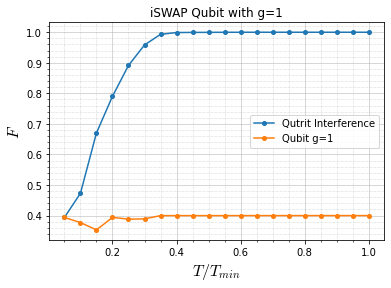

In [15]:
iSWAP_allQtd = pd.read_csv("../ML_Output/Qutrit_iSWAP_AnalyticalSpeedUp_M16_dipoleAll_g1.0_maxT1.0.csv",names=["fidelity","time"])
iSWAP_allQtd.sort_values(by="time",inplace=True)

iSWAP_qtd= pd.read_csv("../ML_Output/Qutrit_iSWAP_AnalyticalSpeedUp_M16_dipoleQtd_g1.0_maxT1.0.csv",names=["fidelity","time"])
iSWAP_qtd.sort_values(by="time",inplace=True)

genPlot("iSWAP Qubit with g=1",iSWAP_allQtd,["Qutrit Interference","Qubit g=1"])

genPlot("iSWAP Qubit with g=1",iSWAP_qtd,["Qutrit Interference","Qubit g=1"])

Here we see that having the $|0\rangle\longleftrightarrow|1\rangle$ and $|0\rangle\longleftrightarrow|2\rangle$ leads to saturation of the analytical protocol! Now let's compare this to our other iSWAP graphs.

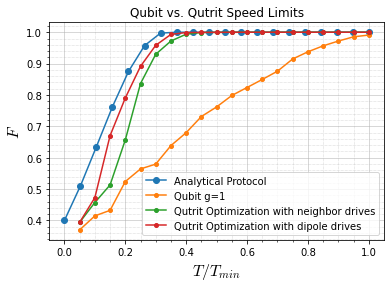

In [16]:
iSWAP_all = pd.read_csv("../ML_Output/Qutrit_iSWAP_AnalyticalSpeedUp_M16_all_g1.0_maxT1.0.csv",names=["fidelity","time"])
iSWAP_all.sort_values(by="time",inplace=True)

plt.plot(Tmin/(pi/2),fidels,"o-")
genPlot("iSWAP Qubit with g=1",iSWAP_QB_DF,["Qutrit Interference","Qubit g=1"])
genPlot("iSWAP Qubit with g=1",iSWAP_all,["Qutrit Interference","Qubit g=1"])
genPlot("Qubit vs. Qutrit Speed Limits",iSWAP_allQtd,["Analytical Protocol","Qubit g=1","Qutrit Optimization with neighbor drives","Qutrit Optimization with dipole drives"])
plt.savefig(os.path.join(os.getcwd(),mainDir,"0711_QbQtCompar.pdf"), format="pdf")

Here we see that our protocol with dipole drives has a slightly faster speed-up than with our neighbor drives. While this is a nice thing to find, we will stick with the neihgboring drive optimization, as it is more realizable and natural. 

Now we will compare the high fidelity saturation time vs. the maximum single qubit drive strength (in terms of the couplings strength). For the time of the analytical protocol, we will sum the dark evolution plus the unintary drives angle divided by the coupling strength. First, our protocol is $$U = X_2 V_1^\dagger V_2^\dagger e^{-iHt} V_1 V_2 X_2$$ where $t=\pi/6$. Writing this in terms of unitary rotations, we have $$U = e^{iH \pi X_2} e^{i\arctan(\sqrt{2})\lambda_{5_1}} e^{i\arctan(\sqrt{2})\lambda_{5_2}} e^{-i\arctan(\sqrt{2})\lambda_{5_2}} e^{-i\arctan(\sqrt{2})\lambda_{5_1}}$$ where $\lambda_5$ is the Gellman matrix that represents a Y rotation between energy states $|0\rangle \longleftrightarrow |2\rangle$. Now the total time will be 

\begin{align*}
    T_{total} &= \pi/g + \arctan(\sqrt{2})/g + \arctan(\sqrt{2})/g + \pi/6 + \arctan(\sqrt{2})/g + \arctan(\sqrt{2})/g + \pi/g\\
    &= \frac{2\pi + 4 \arctan(\sqrt{2})}{g} + \pi/6.
\end{align*}

Now graphs this for $1 \leq g \leq 30$, we have

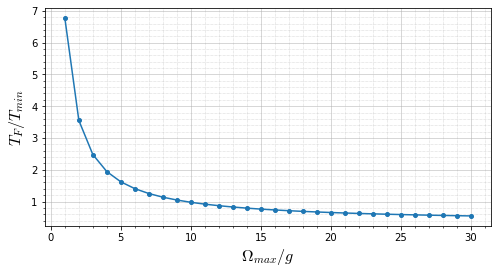

In [40]:
ttotal  = lambda g: (2*pi + 4*arctan(sqrt(2)))/g + pi/6
garr = linspace(1,30,30)
times1 = [ttotal(g)/(np.pi/2) for g in garr]
plt.figure(figsize=(8,4))
plt.xlabel("$\Omega_{max}/g$",fontsize=16)
plt.ylabel("$T_F/T_{min}$",fontsize=16)
#plt.title("Max Single Qubit Drive Frequency vs. Time")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()
plt.plot(garr,times1,marker="o",markersize=4)
plt.savefig(os.path.join(os.getcwd(),mainDir,"0711_QbQtCompar.pdf"), format="pdf")

In [36]:
times1[-1]

0.5477564597292524

Now let's compare this to same graph of the numerical protocol. 

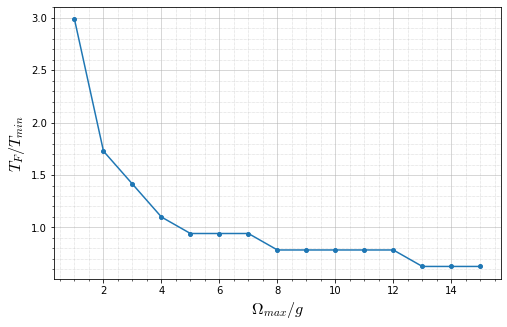

In [38]:
freq = []
times = []
for i in range(1,31):
    if i > 10: file = "../ML_Output/Qutrit_iSWAP_AnalyticalSpeedUp_M16_all_g1.0_maxT1.0_maxD" + str(i) + ".csv"
    else: file = "../ML_Output/Qutrit_iSWAP_AnalyticalSpeedUp_M16_all_g1.0_maxT3.0_maxD" + str(i) + ".csv"
    df = pd.read_csv(file,names=["fidelity","time"])
    df.sort_values(by="time",inplace=True)
    #print(df[df["fidelity"] >= 0.99]["time"].min())
    freq.append(i)
    times.append(df[df["fidelity"] >= 0.99]["time"].min()*np.pi/2)
plt.figure(figsize=(8,5))
plt.xlabel('$\Omega_{max}/g$',fontsize=16)
plt.ylabel('$T_F/T_{min}$',fontsize=16)
#plt.title("Max Freq vs. Min. Relavent Time")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()

numP = 15
#plt.plot(garr[:numP],times1[:numP],"o-")
plt.plot(freq[:numP],times[:numP],marker="o",markersize=4)
#plt.legend(["Analytical","Optimal Control"])
plt.savefig(os.path.join(os.getcwd(),mainDir,"0711_ExpFreq.pdf"), format="pdf")

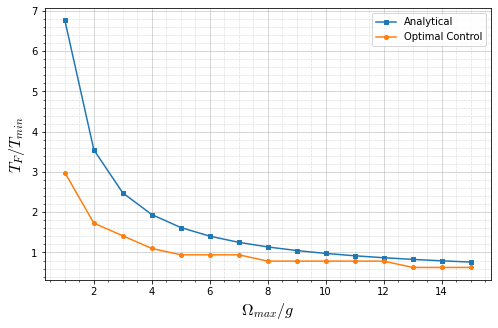

In [39]:
plt.figure(figsize=(8,5))
plt.xlabel('$\Omega_{max}/g$',fontsize=16)
plt.ylabel('$T_F/T_{min}$',fontsize=16)
#plt.title("Max Freq vs. Min. Relavent Time")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()
plt.plot(garr[:numP],times1[:numP],marker="s",markersize=4)
plt.plot(freq[:numP],times[:numP],marker="o",markersize=4)
plt.legend(["Analytical","Optimal Control"])
plt.savefig(os.path.join(os.getcwd(),mainDir,"0711_FreqCompar.pdf"), format="pdf")

## Negative Injection Analysis

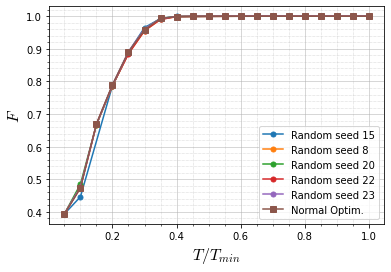

In [29]:
iSWAP_neg15 = pd.read_csv("../Temp_data/ML_Output/Qutrit_iSWAP_AnalyNeg15_M16_dipoleAll_g1.0_maxT1.0.csv",names=["fidelity","time"])
iSWAP_neg15.sort_values(by="time",inplace=True)

iSWAP_neg8 = pd.read_csv("../Temp_data/ML_Output/Qutrit_iSWAP_AnalyNeg8_M16_dipoleAll_g1.0_maxT1.0.csv",names=["fidelity","time"])
iSWAP_neg8.sort_values(by="time",inplace=True)

iSWAP_neg20 = pd.read_csv("../Temp_data/ML_Output/Qutrit_iSWAP_AnalyNeg20_M16_dipoleAll_g1.0_maxT1.0.csv",names=["fidelity","time"])
iSWAP_neg20.sort_values(by="time",inplace=True)

iSWAP_neg22 = pd.read_csv("../Temp_data/ML_Output/Qutrit_iSWAP_AnalyNeg22_M16_dipoleAll_g1.0_maxT1.0.csv",names=["fidelity","time"])
iSWAP_neg22.sort_values(by="time",inplace=True)

iSWAP_neg23 = pd.read_csv("../Temp_data/ML_Output/Qutrit_iSWAP_AnalyNeg23_M16_dipoleAll_g1.0_maxT1.0.csv",names=["fidelity","time"])
iSWAP_neg23.sort_values(by="time",inplace=True)

genPlot("",iSWAP_neg15,["Random seed 15"])
genPlot("",iSWAP_neg8,["Random seed 15","Random seed 8"])
genPlot("",iSWAP_neg20,["Random seed 15","Random seed 8","Random seed 20"])
genPlot("",iSWAP_neg22,["Random seed 15","Random seed 8","Random seed 20","Random seed 22","Random seed 23"])
genPlot("",iSWAP_neg23,["Random seed 15","Random seed 8","Random seed 20","Random seed 22","Random seed 23"])
genPlot("",iSWAP_allQtd,["Random seed 15","Random seed 8","Random seed 20","Random seed 22","Random seed 23","Normal Optim."],"s",6)
plt.savefig(os.path.join(os.getcwd(),mainDir,"0711_NegInj.pdf"), format="pdf")